# BTC-USD @5min

In [2]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [3]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [5]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


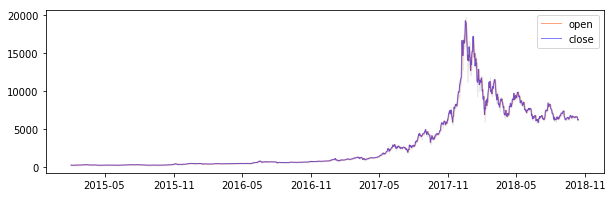

In [7]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [24]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,timestamp,low,high,open,close,volume,weekday
datetime,,,,,,,
2015-01-31 23:00:00,1422745200,224.51,225.69,225.38,224.51,29.638700,5
2015-01-31 23:05:00,1422745500,224.00,225.59,224.62,224.00,52.189176,5
2015-01-31 23:10:00,1422745800,221.99,223.92,223.91,221.99,40.262566,5
2015-01-31 23:15:00,1422746100,218.00,222.00,222.00,218.00,163.490760,5
2015-01-31 23:20:00,1422746400,217.11,218.89,217.92,218.22,96.317898,5


## Test runs

### LSTM

#### 3 epochs

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 139944118949648
Tensor("lstm_27_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_28 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
___________________________________________________________

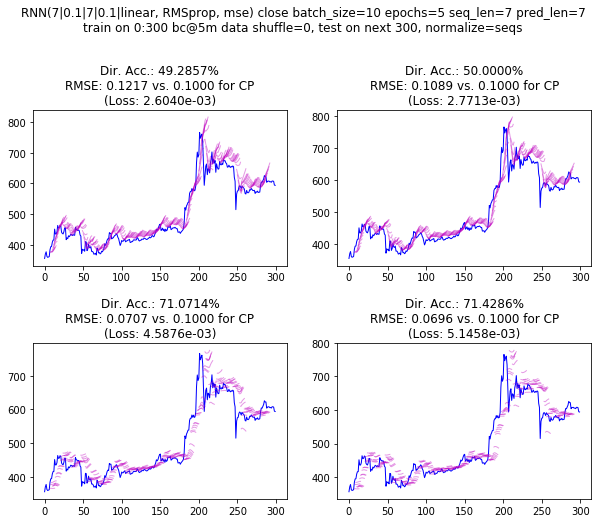

--- 27.940s to run experiment



In [13]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=5,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.015s to model compilation time


--- Created model id: 139915551981392
Tensor("lstm_5_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

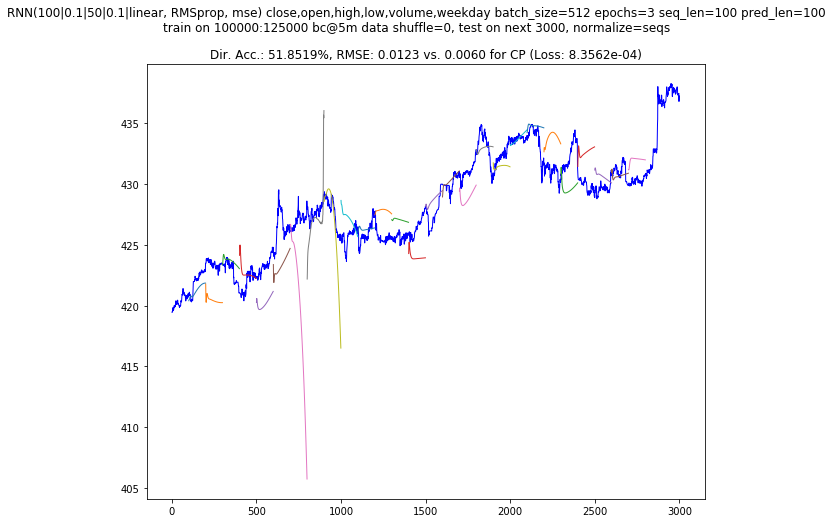

--- 105.233s to run experiment



In [19]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=100000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.019s to model compilation time


--- Created model id: 139915589180752
Tensor("lstm_3_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

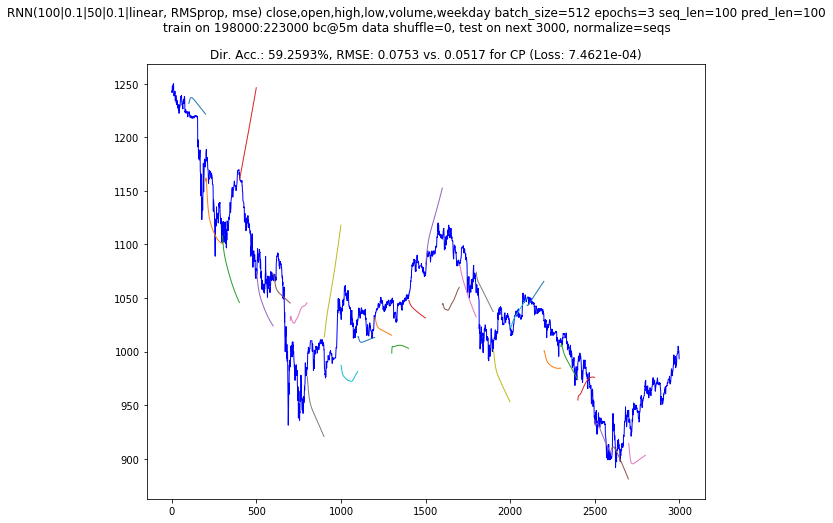

--- 106.737s to run experiment



In [18]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=198000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.015s to model compilation time


--- Created model id: 139915588537168
Tensor("lstm_7_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

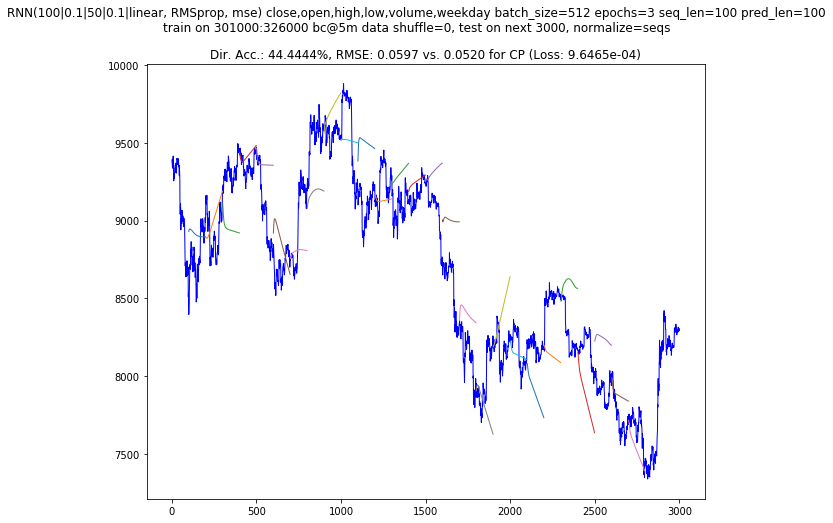

--- 93.540s to run experiment



In [20]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=301000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

#### 6 epochs

data ~ (28000, 6)
--- 0.014s to model compilation time


--- Created model id: 140460899477776
Tensor("lstm_1_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

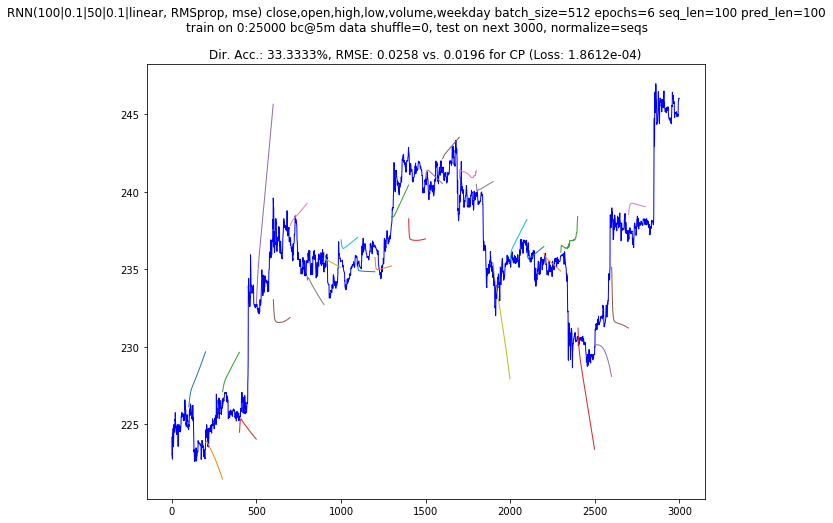

--- 218.908s to run experiment



In [9]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=0,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.014s to model compilation time


--- Created model id: 140460835301392
Tensor("lstm_3_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

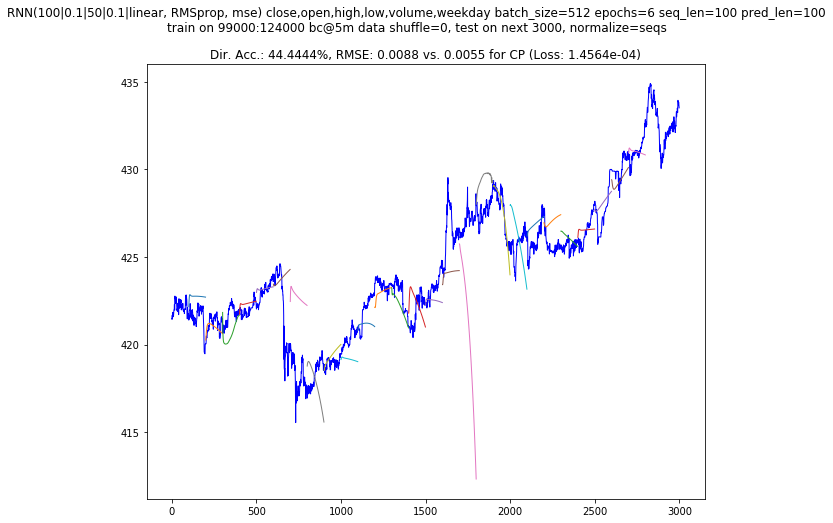

--- 221.750s to run experiment



In [10]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=99000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.014s to model compilation time


--- Created model id: 140461028343056
Tensor("lstm_5_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

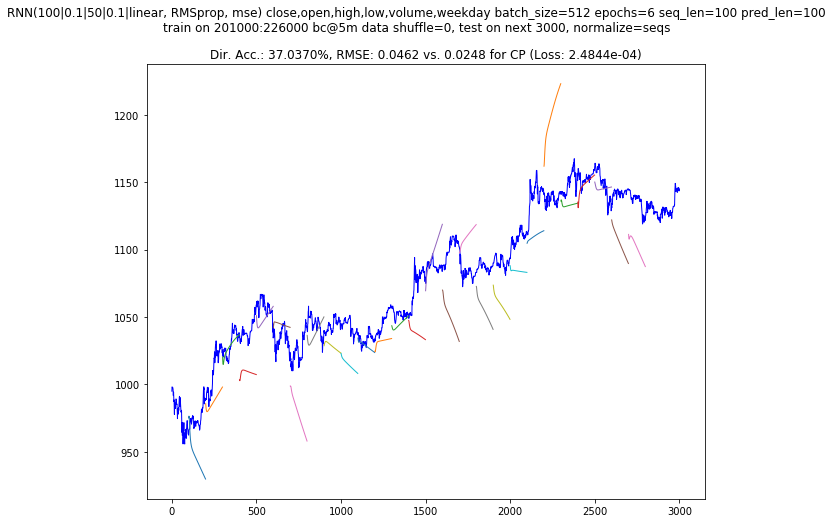

--- 197.485s to run experiment



In [11]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=201000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )